## 记得把loss改成和inceptionv3版本一样的


In [1]:
from torchvision import transforms, utils
from torchvision import datasets
import torch
import matplotlib.pyplot as plt 
from torch.utils import data
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data.sampler import SubsetRandomSampler
import copy
from sklearn.metrics import confusion_matrix

## load data

In [2]:
# def splitData(datadir,val_size = 0.2):
    
#     train_trainsforms = transforms.Compose([transforms.RandomResizedCrop(299),
#                 transforms.RandomHorizontalFlip(),
#                 transforms.RandomRotation(30),
#                 transforms.ToTensor(),
#                 #transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
#                 transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
#     val_trainsforms = transforms.Compose([transforms.RandomResizedCrop(299),
#                 transforms.ToTensor(),
#                 transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
# ])

#     train_data = datasets.ImageFolder(datadir,transform=train_trainsforms)
#     val_data = datasets.ImageFolder(datadir,transform=val_trainsforms)

#     num = len(train_data)                              
#     idx = list(range(num))                         
#     split = int(np.floor(val_size * num))         
#     np.random.shuffle(idx)                              

#     val_idx, train_idx = idx[:split], idx[split:]
#     train_sampler = SubsetRandomSampler(train_idx)            
#     val_sampler  = SubsetRandomSampler(val_idx)
#     train_loader = data.DataLoader(train_data,sampler=train_sampler,batch_size=64)
#     val_loader = data.DataLoader(val_data,sampler=val_sampler,batch_size=64)
    
#     return train_loader,val_loader


In [3]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = 1/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]  
    print(N)
    print(weight_per_class)
    return weight

In [4]:
#train_data_dir = 'OCT2017/test/'
#train_loader, val_loader = splitData(train_data_dir,val_size = 0.2)
batch_size = 128
train_size = 1600
img_size = 224
train_data = datasets.ImageFolder(root='OCT2017/train_limit/', transform=transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
]))

val_data = datasets.ImageFolder(root='OCT2017/val/', transform=transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
]))

test_data = datasets.ImageFolder(root='OCT2017/test/', transform=transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
]))

weights = make_weights_for_balanced_classes(train_data.imgs, len(train_data.classes))
weights = torch.DoubleTensor(weights)
weight_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, train_size)
#weight_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, train_size)

train_loader = data.DataLoader(train_data,
                               batch_size=batch_size,
                               sampler = weight_sampler
                                            )
       

val_loader = data.DataLoader(val_data,
                             batch_size=batch_size,
                             shuffle=True,
                                        )


test_loader = data.DataLoader(test_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            )
       


1600.0
[0.0025, 0.0025, 0.0025, 0.0025]


/home/ruochenwen/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


In [5]:
print(len(val_loader.dataset))
82484.0
[2.232011906372615, 7.4323301495765, 9.859431030360986, 3.164550163053904]


1000


[2.232011906372615, 7.4323301495765, 9.859431030360986, 3.164550163053904]

## load pre-trained model

In [6]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)


In [7]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## parameter setting

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [9]:
feature_extract = False
set_parameter_requires_grad(vgg16, feature_extract)
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs,4)

## optimizer setting

In [10]:
params_to_update = vgg16.parameters()
print
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in vgg16.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    print("fine tune:")
    for name,param in vgg16.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
           
        

# Observe that all parameters are being optimized
#optimizer_vgg16 = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

optimizer_vgg16 = optim.Adam(list(filter(lambda p: p.requires_grad, vgg16.parameters())), lr=5e-6, betas=(0.9, 0.99))
#optimizer_vgg16 = optim.Adam(params_to_update, lr=0.001, betas=(0.9, 0.99))
#optimizer_vgg16 = optim.Adam([{'params': weight_p, 'weight_decay':1e-3},
#                      {'params': bias_p, 'weight_decay':0}], lr=0.001, betas=(0.9, 0.99))

Params to learn:
fine tune:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [11]:
print(len(list(filter(lambda p: p.requires_grad, vgg16.parameters()))))

32


In [12]:
def exp_lr_scheduler(optimizer, epoch, init_lr=5e-5, lr_decay_epoch=5):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    #lr = init_lr * (0.1**(epoch // lr_decay_epoch))
    lr = init_lr 
    if epoch % lr_decay_epoch == 0:
        
        print('LR is set to {}'.format(lr))
 
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
 
    return optimizer


## train model

In [13]:
use_cuda = 1
if use_cuda:
    vgg16 = vgg16.cuda()

In [14]:
def train(model, trainloaders, valloaders, criterion, optimizer, lr_scheduler, num_epoch = 3):
    since =time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss, val_loss = [], []
    
    for epoch in range(num_epoch):
        
        optimizer = lr_scheduler(optimizer, epoch)
        steps = 0
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-'*10)
                
        running_loss = 0.0
        running_corrects = 0 
        for inputs, labels in trainloaders:
            
            model.train()
            steps += 1
            #print(steps)
            
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()
            
            outputs= model(inputs)
            loss_outputs = criterion(outputs, labels)
            loss = loss_outputs 

            _,preds = torch.max(outputs,1)

            loss.backward()
            optimizer.step()
    
            running_loss += loss.item() 
            running_corrects += torch.sum(preds == labels.data)
            #print("loss:", loss.item())
            #if steps % print_every == 0:

        val_running_loss = 0.0
        val_running_corrects = 0
        model.eval()
        step = 0
        with torch.no_grad():
            for inputs, labels in valloaders:
                step += 1
                #print(step)
                inputs = inputs.cuda()
                labels = labels.cuda()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _,preds = torch.max(outputs,1)
                #print(preds)
                val_running_corrects += torch.sum(preds == labels.data)

        train_loss.append(running_loss / len(trainloaders))
        val_loss.append(val_running_loss / len(valloaders))
        
        #train_acc = running_corrects.double() / len(trainloaders.dataset)
        #val_acc = val_running_corrects.double() / len(valloaders.dataset)
       
        train_acc = running_corrects.double() / len(trainloaders.dataset)
        val_acc = val_running_corrects.double() / len(valloaders.dataset)
        
        print(f"Train loss: {running_loss / len(trainloaders):.3f}.."
              f"Train accuracy:{train_acc:.3f}.."
              f"Val loss: {val_running_loss/len(valloaders):.3f}.."
              f"Val accuracy: {val_acc:.3f}.."
             )

                
        # deep copy the model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            val_acc_history.append(val_acc)

   # print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    conf_matrix = confusion_matrix(preds.data.cpu().numpy(), labels.data.cpu().numpy())
    print(conf_matrix)
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    #return model, val_acc_history  
    return model, val_acc_history, train_loss, val_loss, conf_matrix
    

LR is set to 5e-05
Epoch 1/30
----------
Train loss: 1.085..Train accuracy:0.520..Val loss: 0.718..Val accuracy: 0.693..
Epoch 2/30
----------
Train loss: 0.616..Train accuracy:0.738..Val loss: 0.536..Val accuracy: 0.784..
Epoch 3/30
----------
Train loss: 0.461..Train accuracy:0.829..Val loss: 0.419..Val accuracy: 0.839..
Epoch 4/30
----------
Train loss: 0.383..Train accuracy:0.864..Val loss: 0.393..Val accuracy: 0.854..
Epoch 5/30
----------
Train loss: 0.376..Train accuracy:0.868..Val loss: 0.402..Val accuracy: 0.845..
LR is set to 5e-05
Epoch 6/30
----------
Train loss: 0.336..Train accuracy:0.881..Val loss: 0.425..Val accuracy: 0.840..
Epoch 7/30
----------
Train loss: 0.274..Train accuracy:0.904..Val loss: 0.407..Val accuracy: 0.855..
Epoch 8/30
----------
Train loss: 0.285..Train accuracy:0.894..Val loss: 0.441..Val accuracy: 0.852..
Epoch 9/30
----------
Train loss: 0.258..Train accuracy:0.906..Val loss: 0.382..Val accuracy: 0.871..
Epoch 10/30
----------
Train loss: 0.202..Tr

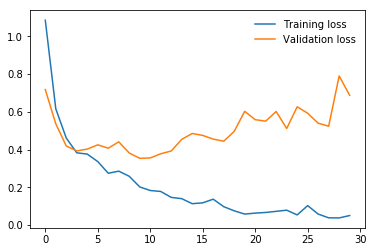

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optimizer_vgg16
_, hist,train_loss,val_loss,cm = train(vgg16, train_loader, val_loader, criterion, optimizer, exp_lr_scheduler, num_epoch =30)

plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(frameon=False)
plt.savefig("model_3.png")
plt.show()





In [16]:
print(cm)

[[23  1  0  1]
 [ 1 27  2  2]
 [ 2  0 20  0]
 [ 0  1  1 23]]


In [17]:
def inference(model, testloaders, criterion):
    test_running_corrects = 0
    test_running_loss = 0
    with torch.no_grad():
        for inputs, labels in testloaders:
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _,preds = torch.max(outputs,1)
            
            test_running_corrects += torch.sum(preds == labels.data)

    test_acc = test_running_corrects.double() / len(testloaders.dataset)
    conf_matrix = confusion_matrix(preds.data.cpu().numpy(), labels.data.cpu().numpy())
    print(conf_matrix)
    print(f"Loss of the network on the 1000 test images: {test_running_loss/len(testloaders):.3f}.."
          f"Accuracy of the network on the 1000 test images: {test_acc:.3f}.."
         )

In [18]:
inference(vgg16, test_loader, criterion)

[[27  0  4  0]
 [ 0 25  0  0]
 [ 0  0 21  0]
 [ 0  0  0 27]]
Loss of the network on the 1000 test images: 0.129..Accuracy of the network on the 1000 test images: 0.968..
